<a href="https://colab.research.google.com/github/IJLee0812/PyTorch-Study/blob/main/FT_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Tutorial(with PyTorch)

- Reference : https://colab.research.google.com/github/Ankur3107/colab_notebooks/blob/master/classification/BERT_Fine_Tuning_Sentence_Classification_v2.ipynb#scrollTo=L9vxxTBsuL24

In [1]:
import torch

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Huggingface 라이브러리 설치(허깅페이스에서 제공하는 transformers 패키지)

In [2]:
!pip install transformers

# CoLA 데이터셋 : 문법적으로 정확하거나 잘못된 것으로 레이블이 지정된 일련의 문장 데이터셋
- 데이터베이스는 깃허브의 https://nyu-mll.github.io/CoLA/에서 호스팅

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8828cb7701945552ad42ea67dce46b39da7878bd66e58cfdcad19687e7ec3bdf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [5]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


# 구문 분석
- 영어 문법 상, 정확한 문법이면 label = 1(acceptable), 부정확한 문법이면 label = 0(unacceptable) 인 데이터셋임을 알 수 있음.

In [6]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
8345,ad03,1,NaN,That the golden thread would show Jason his pa...
6974,m_02,1,NaN,We spent yesterday cooking.
4779,ks08,1,NaN,Who do you think visited Seoul last year?
1572,r-67,1,NaN,He'll bring me a hot dog if he sees one.
3028,l-93,0,*,I hunted the woods for game.
5263,b_82,1,NaN,The men would not all have been working.
7467,sks13,0,*,Is not Bill sick?
5311,b_82,1,NaN,"Though he may seem intelligent, he does not se..."
1534,r-67,1,NaN,John scratched his arm and the boy who knew Ma...
3999,ks08,1,NaN,"Broadly speaking, the project was successful."


In [7]:
df.loc[df.label == 1].sample(5)[['sentence', 'label']] # 문법적으로 알맞은 문장들 랜덤 5개 추출

,sentence,label
1415,My friends Mike talked to about politics yeste...,1
5759,Many soldiers have claimed bottled water satis...,1
2094,"The police read the detainees' rights to them,...",1
2229,This machine records well.,1
2058,I promise a good time to all who come.,1


In [8]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']] # 문법적으로 틀린 문장들 랜덤 5개 추출

,sentence,label
3871,John put his gold to be under the bathtub.,0
2585,Cora coiled at the rope around the post.,0
1826,That beans he likes is now obvious.,0
2483,Lydia pocketed the change in her pocket.,0
4088,Fred is counting on for Tom to make an announc...,0


# 토큰화 및 입력 포맷
- BERT에 텍스트를 공급하려면, 토큰으로 분할한 다음 -> 토큰을 토큰화기 어휘의 인덱스에 매핑해야 한다.

In [9]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# save sentences from original df.
sentences = df['sentence'].tolist()

for i in range(5):
    # Print the original sentence.
    print(' Original: ', sentences[i])

    # Print the sentence split into tokens.
    print('Tokenized: ', tokenizer.tokenize(sentences[i]))

    # Print the sentence mapped to token ids.
    print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[i])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]
 Original:  One more pseudo generalization and I'm giving up.
Tokenized:  ['one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.']
Token IDs:  [2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012]
 Original:  One more pseudo generalization or I'm giving up.
Tokenized:  ['one', 'more', 'pseudo', 'general', '##ization', 'or', 'i', "'", 'm', 'giving', 'up', '.']
Token IDs:  [2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012]
 Original:  The more we study verbs, the crazier they get.
Tokenized:  ['the', 'more', 'we', 'study', 'verbs', ',', 'the', 'cr', '##azi', '##er', 'they', 'g

- 실제 모든 문장을 변환할 때, tokenize와 convert_tokens_to_ids를 위와 같이 별도로 호출하는 대신, tokenize.encode 함수를 사용하여 두 단계를 모두 처리한다.

# 데이터셋 토큰화

- 트랜스포머 라이브러리는 대부분의 구문 분석 및 데이터 준비 단계를 처리할 수 있는 encode 함수 제공.
- 그러나 텍스트를 인코딩할 준비가 되기 전에 패딩 / 잘라내기를 위한 "최대 문장 길이"를 결정해야 함.

<br>

### tokenizer.encode_plus 함수
- 문장을 토큰으로 분할
- 스페셜 [CLS] 및 [SEP] 토큰을 추가함
- 토큰을 ID에 매핑
- 모든 문장을 같은 길이로 padding or cutting
- 실제 토큰을, [PAD] 토큰(패딩)과 명시적으로 구별하는 어텐션 마스크를 생성함 -> plus 함수 사용해야 함





In [11]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [12]:
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length = 64, # 47 -> 64로 널널하게 설정(가장 크거나 같은 2의 승수)
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Train / Validation 데이터셋 분할

In [13]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split. Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset)) # 90퍼센트
val_size = len(dataset) - train_size # 100 - 90 = 10퍼센트

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


- 배치 사이즈 = 32로 설정, 데이터로더 설정

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 분류 모델 로드하기

###  pretrained BERT를 수정하여, 분류를 위한 출력을 제공한 다음 전체 모델이 작업에 적합할 때까지 데이터셋에서 모델을 계속 훈련코자 함.

- 허깅페이스에서, 파인튜닝을 위해 제공되는 BertForSequenceClassification 사용
- 입력 데이터를 공급함에 따라, pretrained BERT 모델 전체와, 훈련되지 않은 추가 분류 계층이 특정 작업에 대해 훈련됨.

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 대소문자 구분 않는 모델
    num_labels = 2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False
)

model.cuda() # GPU에 모델을 올림

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 최적화 및 LR 스케줄러

### 모델이 로드되었으므로, 저장된 모델 내에서 하이퍼파라미터를 가져와야 한다. 파인튜닝을 아래 값 중 하나를 선택할 것을 권장한다.(BERT 논문 appendix A.3)
- Batch Size : 16, 32
- LR(AdamW) : 5e-5, 3e-5, 2e-5
- Num of epochs : 2, 3, 4

### 값 선택
- Batch Size : 32(위에서 DataLoader 생성 시 설정하였음)
- LR : 2e-5
- Num of epochs : 4

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 # for prevent divided by 0
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs # Num of batches * Num of epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 학습 루프(중요)

**Training Phase:**

- 데이터 인풋 및 레이블 받기
- 가속을 위해 GPU에 데이터 로드
- 이전 패스에서 계산된 그래디언트 지움(zero_grad())
    - 파이토치에서는 기본적으로 그래디언트 누적됨(RNN 등에 유용)
- Forward pass
- Backward pass(역전파)
- 네트워크에 Optimizer.step()을 사용하여 매개 변수를 업데이트하도록 지시
- 진행 상황 모니터링을 위한 추적 변수


**Evalution Phase:**

- 데이터 인풋 및 레이블 받기
- 가속을 위해 GPU에 데이터 로드
- Forward pass
- Validation data에 대한 loss 계산 및 진행률 모니터링을 위한 변수 추적


In [20]:
import numpy as np
import time
import datetime
import random

# 예측 결과 vs. 실제 레이블과 비교 시 accuracy 계산을 위한 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat  =labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 경과시간 형식 지정
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [33]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# 랜덤시드 42 국룰
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

training_stats = []

total_t0 = time.time()


epochs = 2 # 4로 설정 시, 오버피팅이 발생하는 것을 볼 수 있음. 추후 더 낮게 설정 후 prediction accuracy 비교

for epoch_i in range(0, epochs): # epoch_i 는 인덱스 표시용

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 각 epoch당 시간 측정 시작 시점
    t0 = time.time()

    # train loss 초기화
    total_train_loss = 0

    model.train() # 모델을 학습 모드로 전환

    for step, batch in enumerate(train_dataloader):

        # 40 배치 처리시마다 진행상황 출력
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 'batch' contains 3 pytorch tensors:
        # [0] : input ids
        # [1] : attention masks
        # [2] : labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 누적 방지
        model.zero_grad()

        # - - - FF 통과 및 loss, logits 추출 : 정상작동 되도록 원본 소스코드에서 수정 진행 - - -
        outputs = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        loss = outputs.loss
        logits = outputs.logits
        # - - - FF 통과 및 loss, logits 추출 : 정상작동 되도록 원본 소스코드에서 수정 진행 - - -

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # 역전파 계산
        loss.backward()

        # Gradient Clipping 수행(Exploding Gradient 방지, l2-norm을 1로 클리핑)
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step() # LR 업데이트

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval() # 모델을 평가 모드로 전환

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad(): # Eval Mode : 그래디언트 업데이트 X

            outputs = model(b_input_ids,
                            token_type_ids = None,
                            attention_mask = b_input_mask,
                            labels = b_labels)

            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()

        # GPU -> CPU로 값 옮겨서, 위에서 정의한 accuracy evalutaion 함수 사용
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )



print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


<ipython-input-33-12f48369fd47>:65: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:26.
  Batch   120  of    241.    Elapsed: 0:00:39.
  Batch   160  of    241.    Elapsed: 0:00:53.
  Batch   200  of    241.    Elapsed: 0:01:06.
  Batch   240  of    241.    Elapsed: 0:01:19.

  Average training loss: 0.02
  Training epcoh took: 0:01:19

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.84
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:26.
  Batch   120  of    241.    Elapsed: 0:00:39.
  Batch   160  of    241.    Elapsed: 0:00:52.
  Batch   200  of    241.    Elapsed: 0:01:05.
  Batch   240  of    241.    Elapsed: 0:01:18.

  Average training loss: 0.02
  Training epcoh took: 0:01:18

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.84
  Validation took: 0:00:03

Training complete!
Total training took 0:02:43 (h:mm:ss)


# 학습 결과 확인(epoch = 4)
- Training Loss가 각 epoch에 따라 감소하는 반면, Validation Loss는 증가한다. = 오버피팅이 발생했다.

In [29]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.187401,0.503735,0.827932,0:01:19,0:00:03
2,0.212307,0.463063,0.840664,0:01:18,0:00:03
3,0.140937,0.546772,0.838349,0:01:18,0:00:03
4,0.118686,0.546772,0.838349,0:01:18,0:00:03


# 학습 결과 확인 (epoch = 3)

In [32]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.067816,1.037596,0.802083,0:01:18,0:00:03
2,0.098796,0.663746,0.837191,0:01:18,0:00:03
3,0.088229,0.718556,0.838349,0:01:18,0:00:03


# 학습 결과 확인 (epoch = 2)

In [34]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.015949,0.837111,0.833719,0:01:19,0:00:03
2,0.017893,0.837111,0.833719,0:01:18,0:00:03


# Test Set에서의 성능
- [Matthew의 상관계수](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)를 사용하여 예측을 평가함. CoLA의 성능을 평가하기 위한 범용 메트릭.
- -1(bad) ~ +1(good)

### 1. 데이터 준비

In [37]:
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence
    #   (2) Prepend the `[CLS]` token to the start
    #   (3) Append the `[SEP]` token to the end
    #   (4) Map tokens to their IDs
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )

    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size
batch_size = 32

# Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### 2. Test Set에 대한 Evaluation

- Fine-Tuned Model에 대하여, Test Set에 대한 Prediction을 Evaluate 가능

In [39]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Predicting labels for 516 test sentences...
    DONE.
Positive samples: 354 of 516 (68.60%)


Calculating Matthews Corr. Coef. for each batch...


<ipython-input-40-d5ddef004a97>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


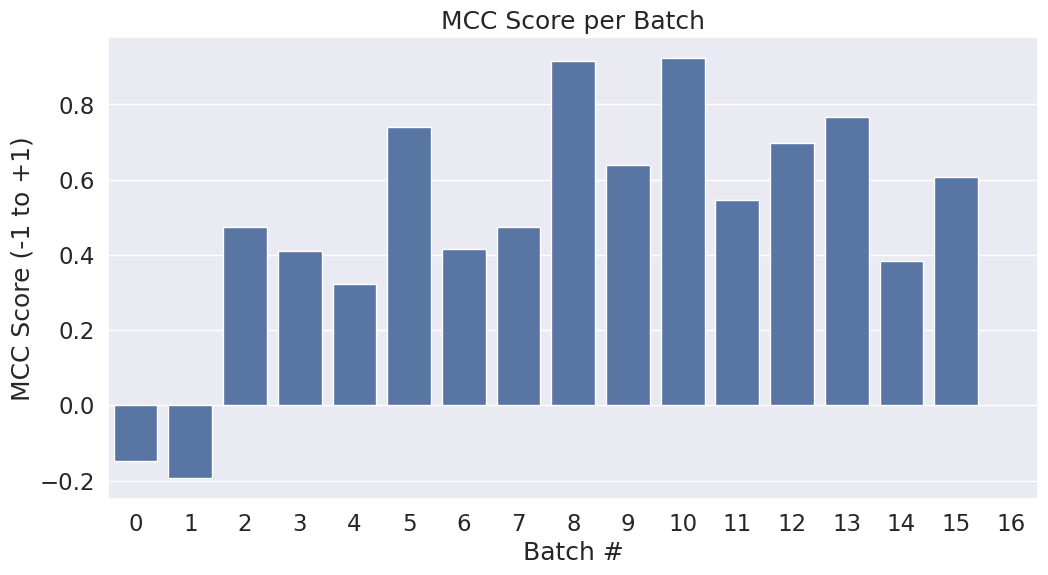

In [40]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

- 모든 Batch에 대한 결과를 결합하여 최종 MCC score(Metric) 계산
- 라이브러리는 이 벤치마크에 대한 예상 정확도를 49.23으로 문서화하였음. 데이터셋 크기가 작으므로 정확도 수치는 실행 간 크게 달라질 수 있음.

In [41]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.509
